## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction



<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [3]:
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [4]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [5]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [6]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [7]:
(df.groupby('landing_page')).group.value_counts()

landing_page  group    
new_page      treatment    145311
              control        1928
old_page      control      145274
              treatment      1965
Name: group, dtype: int64

In [8]:
1928+1965

3893

f. Do any of the rows have missing values?

In [9]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [10]:
df2=df.copy()
dropped = df2.query('(landing_page=="new_page" & group == "control") or (landing_page=="old_page" & group == "treatment")')
df2.drop(dropped.index, axis=0, inplace=True)

In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [12]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [13]:
df2[df2['user_id'].duplicated()] 

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [14]:
df2.query('user_id==773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [15]:
df2.drop(2893,axis=0,inplace=True)

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
control_conv = df2.query('group=="control"').converted.mean()
control_conv

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
ttt_conv = df2.query('group=="treatment"').converted.mean()
ttt_conv

0.11880806551510564

d. What is the probability that an individual received the new page?

In [19]:
df2.query('landing_page=="new_page"').shape[0]/df2.shape[0]

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

> There is no evidence that the new page leads to more conversions as the mean conversions for the treatment(new page) group is less than the mean conversions for the control(old page) group.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

> Null : P<sub>new</sub> - P<sub>old</sub> <= 0

> Alternative : P<sub>new</sub> - P<sub>old</sub> > 0                                 

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [28]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [29]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [30]:
n_new = df2.query('group=="treatment"').shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [31]:
n_old = df2.query('group=="control"').shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [32]:
new_page_converted = np.random.binomial(1,p=p_new,size=n_new)

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [33]:
old_page_converted = np.random.binomial(1,p=p_old,size=n_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [34]:
obs_diff = new_page_converted.mean()-old_page_converted.mean()
obs_diff

0.00053485730571095624

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [35]:
# After Review
new_page_converted = np.random.binomial(n_new, p_new, 10000)/n_new
old_page_converted = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_page_converted - old_page_converted

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

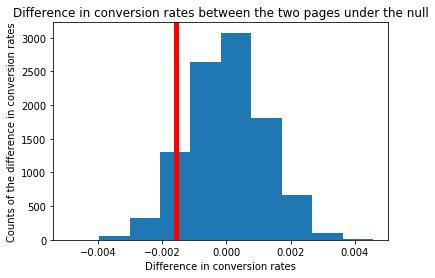

In [39]:
plt.hist(p_diffs);
plt.axvline(x=ab_diff,color='red',linewidth=5);
plt.xlabel('Difference in conversion rates');
plt.ylabel('Counts of the difference in conversion rates');
plt.title('Difference in conversion rates between the two pages under the null')
plt.show();

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [38]:
ab_diff = df2.query('landing_page=="new_page"').converted.mean()-df2.query('landing_page=="old_page"').converted.mean()
(p_diffs>ab_diff).mean()

0.91139999999999999

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

> the p value: It means that the probability of achieveing (our observed difference or a more extreme difference in favor of the alternative hypothesis) due to pure chance (while the null hypothesis is true with no real difference in the conversion rates between the two pages).

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [40]:
import statsmodels.api as sm

convert_old = df2.query('landing_page=="old_page"').converted.sum()
convert_new = df2.query('landing_page=="new_page"').converted.sum()
n_old = df2.query('landing_page=="old_page"').shape[0]
n_new = df2.query('landing_page=="new_page"').shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [41]:
import statsmodels.stats as stats
stats.proportion.proportions_ztest([convert_new,convert_old],[n_new,n_old],alternative='larger')

(-1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

> The z-score describes the distance from the mean on the standard normal distribution. The z-score is less than the z-critical value of 1.96, so we are likely to have such a sample from the sampling distribution given an alpha of 0.05.

> The p-value means the 90% of the conversion rates under the null hypothesis are in favor of the alternative hypothesis more than our observed difference and this is based on pure chance not on a real difference in the conversion rates between the new and the old pages. There is no sufficient evidence to reject the null hypothesis.

> Yes, the findings agree with the findings in parts j and k.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

> Logsitic Regression

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [42]:
df2['intercept']=1
df2['ab_page']=pd.get_dummies(df['group'])['treatment']

c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [43]:
lm=sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results=lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [44]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-04-25 23:22 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>

> The p value of ab_page is 0.19

> The p-value with the ab_pagee is the probability that we obtain (this difference in conversion rate or more extreme difference between the old and new page) due to pure chance. So, this is a two-sided test where the alternative hypothesis is that the difference between the 2 pages doesn't equal 0. On the contrary, the alternative hypothesis in part 2 was that the new page is associated with higher conversion rate than the old page, so it's a one-sided test.

> In the logistic regression model, the p value is the probability distribution from the 2 tails on the right and left of the + or - z score, while in part 2 the p value is the probability distribution right to the z score which is negative meaning that the p value will be greater than 50%

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

> We should consider other predictive factors so that we could predict the conversion rate better and fit a better model. However, adding additional terms that has no independent correlation with the conversion rate will mislead us when they are correlated to other predictive variables (multicolinearity). This will cause coefficients to be flipped away from what is predicted from the simple linear regression model and bivariate plots.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [45]:
df_countries = pd.read_csv('countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [46]:
df2 = df2.set_index('user_id').join(df_countries.set_index('user_id'))
df2.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country
user_id,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [47]:
df2.country.unique()

array(['US', 'CA', 'UK'], dtype=object)

In [48]:
df2[['CA','UK','US']]=pd.get_dummies(df2['country'])
df2.drop('US',axis=1,inplace=True)

In [49]:
lm=sm.Logit(df2['converted'],df2[['intercept','ab_page','CA','UK']])
results=lm.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-04-25 23:22 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
CA           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

> The country impact on the conversion rate isn't statistically significant as it has a p-value greater than 0.05

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [50]:
df2['page_CA'] = df2['ab_page']*df2['CA']
df2['page_UK']=df2['ab_page']*df2['UK']
lm=sm.Logit(df2['converted'],df2[['intercept','ab_page','CA','UK','page_CA','page_UK']])
results=lm.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-04-25 23:23 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
CA           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
UK           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
page_CA      -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
page_UK       0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
==================================================================

"""

> The coefficients associated with the interaction between the page and the countries aren't statistically significant and there's an overlap between their confidence intervals, So we don't have enough evidence to conclude that there's significant interaction between country and page.

## Summary & Conclusion

> Our p values aren't statistically significant despite multiple testing, so we don't have enough evidence to say that the new page or countries have an impact on the conversion rate.

> I think our sample size is large enough. Although running the experiment for larger time might give us statistically significant p-values, the effect is unlikely to have practical significance.

> Based on our results, we conclude that the company should keep the old page.